# Robust PCA (Principlal Component Pursuit)

外れ値がある場合のPCAは，外れ値に大きく影響を受けてしまう．

In [1]:
import numpy as np
import pylab as plt
from sklearn.decomposition import PCA
%matplotlib inline

/home/kei/anaconda3/envs/ccann/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  


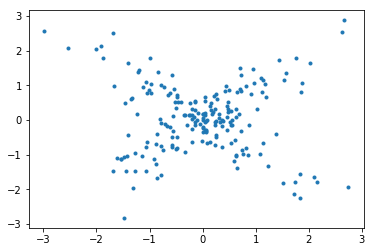

In [96]:
# data1 = np.random.multivariate_normal(np.zeros(2), [[0,0], [0,1]], 100)
# data2 = np.random.multivariate_normal(np.zeros(2), [[1,0], [0,0]], 100)


data1 = np.random.multivariate_normal(np.zeros(2), [[1, 0.9], [0.9, 1]], 100)
data2 = np.random.multivariate_normal(np.zeros(2), [[-1, 0.9], [0.9, -1]], 100)
data = np.r_[data1, data2]

data = np.c_[data, np.zeros(len(data))]

data[-1] = [0,0,20]
plt.scatter(data[:,0], data[:,1], marker=".")
plt.show()

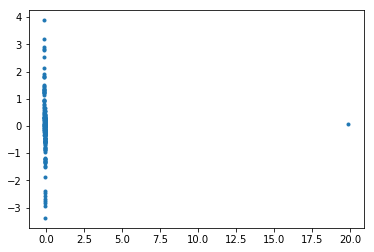

In [97]:
pca = PCA()
pcaed = pca.fit_transform(data)
plt.scatter(pcaed[:,0], pcaed[:,1], marker=".")
plt.show()

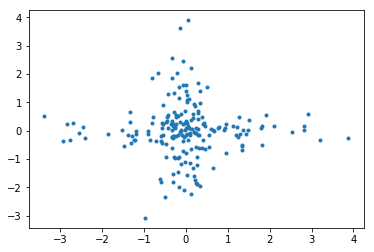

In [98]:
pca = PCA()
pcaed = pca.fit_transform(data[:-1])
plt.scatter(pcaed[:,0], pcaed[:,1], marker=".")
plt.show()

Robust PCAでは外れ値を考慮して，射影を求める．

$\min \|L\|_* + \lambda \|S\|_1, \ \ s.t.\ L+S=M$

In [99]:
M = data
M.shape

(200, 3)

In [100]:
S = 0
Y = 0
μ = 1
λ = 1/(max(M.shape))**0.5
print(λ)
nb_epochs = 100

0.07071067811865475


In [101]:
def shrink(x, τ):
    shape = x.shape
    x = x.reshape(-1)
    temp = np.apply_along_axis(lambda a: np.max(np.c_[np.abs(a)-τ, np.zeros(len(a))], axis=1), 0, x)
    return np.sign(x.reshape(shape)) * temp.reshape(shape)

In [102]:
for i in range(nb_epochs):
    U, Σ, V = np.linalg.svd(M - S + Y/μ, full_matrices=False)
    L = np.matmul(U * shrink(Σ, 1/μ), V)
    S = shrink(M - L + Y/μ, λ/μ)
    Y = Y + μ*(M - L - S)

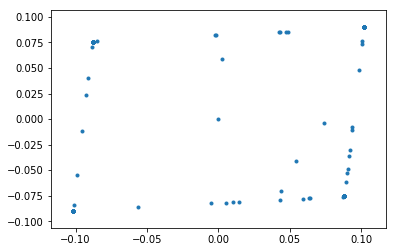

In [103]:
plt.scatter(L[:,0], L[:,1], marker=".")
plt.show()

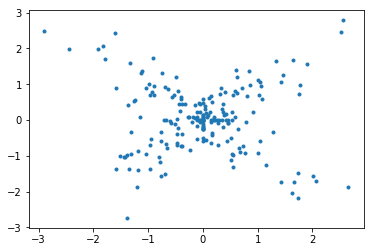

In [104]:
plt.scatter(S[:,0], S[:,1], marker=".")
plt.show()

In [106]:
# -*- coding: utf-8 -*-
"""
An implementation of the Principal Component Pursuit algorithm for robust PCA
as described in `Candes, Li, Ma, & Wright <http://arxiv.org/abs/0912.3599>`_.

An alternative Python implementation using non-standard dependencies and
different hyperparameter choices is available at:

http://blog.shriphani.com/2013/12/18/
    robust-principal-component-pursuit-background-matrix-recovery/

"""

from __future__ import division, print_function

__all__ = ["pcp"]

import time
import fbpca
import logging
import numpy as np
from scipy.sparse.linalg import svds


def pcp(M, delta=1e-6, mu=None, maxiter=500, verbose=False, missing_data=True,
        svd_method="approximate", **svd_args):
    # Check the SVD method.
    allowed_methods = ["approximate", "exact", "sparse"]
    if svd_method not in allowed_methods:
        raise ValueError("'svd_method' must be one of: {0}"
                         .format(allowed_methods))

    # Check for missing data.
    shape = M.shape
    if missing_data:
        missing = ~(np.isfinite(M))
        if np.any(missing):
            M = np.array(M)
            M[missing] = 0.0
    else:
        missing = np.zeros_like(M, dtype=bool)
        if not np.all(np.isfinite(M)):
            logging.warn("The matrix has non-finite entries. "
                         "SVD will probably fail.")

    # Initialize the tuning parameters.
    lam = 1.0 / np.sqrt(np.max(shape))
    if mu is None:
        mu = 0.25 * np.prod(shape) / np.sum(np.abs(M))
        if verbose:
            print("mu = {0}".format(mu))

    # Convergence criterion.
    norm = np.sum(M ** 2)

    # Iterate.
    i = 0
    rank = np.min(shape)
    S = np.zeros(shape)
    Y = np.zeros(shape)
    while i < max(maxiter, 1):
        # SVD step.
        strt = time.time()
        u, s, v = _svd(svd_method, M - S + Y / mu, rank+1, 1./mu, **svd_args)
        svd_time = time.time() - strt

        s = shrink(s, 1./mu)
        rank = np.sum(s > 0.0)
        u, s, v = u[:, :rank], s[:rank], v[:rank, :]
        L = np.dot(u, np.dot(np.diag(s), v))

        # Shrinkage step.
        S = shrink(M - L + Y / mu, lam / mu)

        # Lagrange step.
        step = M - L - S
        step[missing] = 0.0
        Y += mu * step

        # Check for convergence.
        err = np.sqrt(np.sum(step ** 2) / norm)
        if verbose:
            print(("Iteration {0}: error={1:.3e}, rank={2:d}, nnz={3:d}, "
                   "time={4:.3e}")
                  .format(i, err, np.sum(s > 0), np.sum(S > 0), svd_time))
        if err < delta:
            break
        i += 1

    if i >= maxiter:
        logging.warn("convergence not reached in pcp")
    return L, S, (u, s, v)


def shrink(M, tau):
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S


def _svd(method, X, rank, tol, **args):
    rank = min(rank, np.min(X.shape))
    if method == "approximate":
        return fbpca.pca(X, k=rank, raw=True, **args)
    elif method == "exact":
        return np.linalg.svd(X, full_matrices=False, **args)
    elif method == "sparse":
        if rank >= np.min(X.shape):
            return np.linalg.svd(X, full_matrices=False)
        u, s, v = svds(X, k=rank, tol=tol)
        u, s, v = u[:, ::-1], s[::-1], v[::-1, :]
        return u, s, v
    raise ValueError("invalid SVD method")

In [108]:
L, S, (u, s, v) = pcp(M)

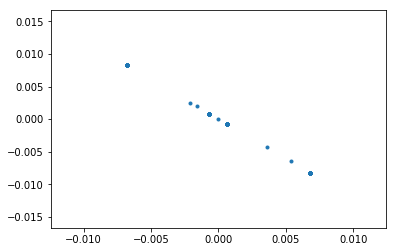

In [109]:
plt.scatter(L[:,0], L[:,1], marker=".")
plt.show()

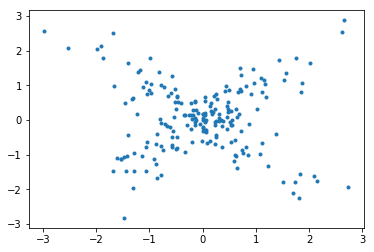

In [110]:
plt.scatter(S[:,0], S[:,1], marker=".")
plt.show()